## Lab 3 2025 EDPN

Allen A. Isidora M. Iñaki R. Grupo 2.

In [1]:
# importar gmsh

try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

--2025-04-23 21:38:45--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.42K  --.-KB/s    in 0s      

2025-04-23 21:38:45 (42.9 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3497/3497]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/2851dc01/releases/h5py-install.sh
+ [[ https://gith

In [2]:
# importar dolfinx

try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

--2025-04-23 21:39:34--  https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4339 (4.2K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   4.24K  --.-KB/s    in 0s      

2025-04-23 21:39:34 (49.4 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [4339/4339]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/d7ddd552/release

In [3]:
# instalar e importar pyvista

!pip install pyvista
import pyvista as pv

In [4]:
# gmsh
import gmsh

# ufl
import ufl

# MPI
from mpi4py import MPI

# dolfinx
import dolfinx.fem.petsc
from dolfinx.io import XDMFFile, distribute_entity_data, gmshio
from dolfinx import io, cpp, fem, mesh, plot

# PETSc
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType, Mat

# SLEPc
from slepc4py import SLEPc

# numpy
import numpy as np

# pyplot
import matplotlib.pyplot as plt
from matplotlib import cm

# time
import time

In [5]:
!pip install PyVirtualDisplay

from pyvirtualdisplay import Display
from dolfinx.plot import vtk_mesh

display = Display(visible=0, size=(600, 400))
display.start()

pv.OFF_SCREEN=False
pv.set_jupyter_backend("static")
pv.plotting.close_all()

True

## **Barra Anclada por un Borde**

Considere una barra recta con forma de prisma cuadrangular de largo $L$, ancho $W$ y con densidad de material $\rho$ que es posicionada ortogonalmente a un campo gravitatorio uniforme $\mathbf{g}$, anclada por un extremo y deformada bajo la acción de su propio peso.

### **P1**
[1.0pts]

> Suponga que el sistema de coordenadas empleado como referencia es tal que el campo gravitatorio es vertical y hacia abajo, es decir, $\mathbf{g}=(0,0,-g)^T$, con $g>0$. Escriba el problema $(E)$ asociado a la configuración descrita. **Indicación:** Defina $\Omega$, $\partial\Omega_D$, $\partial\Omega_N$, $F$, $\mathbf{u}_D$ y $T$.

$$\Omega = [0,L] \times [0,W] \times [0,W]$$
$$ ∂ \Omega_{D} =\{0\} \times [0,W] \times [0,W] $$
$$ ∂ \Omega_{N} =  \partial \big((0,L] \times (0,W] \times (0,W])$$

<br>
\begin{align*}
(E) \quad
\begin{cases}
  -\nabla\cdot \left(2\mu\mathbf{e}(\mathbf{u})+\lambda tr(\mathbf{e}(\mathbf{u}))I\right) = \rho \cdot \vec{g} & \text{ en }\Omega, \\
  \mathbf{u} = 0 & \text{ en }\partial\Omega_D, \\
  \sigma\cdot \mathbf{n} =0 & \text{ en }\partial\Omega_N
\end{cases}
\end{align*}<br>


La formulación débil del problema $(E)$ corresponde a encontrar una función $\mathbf{u}\in \hat{V}:=\left\{\mathbf{w}\in H^1(\Omega,\mathbb{R}^N):\mathbf{w}=\mathbf{u}_D \text{ en } \partial \Omega_D\right\}$ tal que:

$$ \displaystyle\int_\Omega\sigma(\mathbf{u}):\mathbf{e}(\mathbf{v})\text{d}\mathbf{x}=\int_\Omega F\cdot \mathbf{v}\text{d}\mathbf{x} + \int_{\partial\Omega_N}T\cdot \mathbf{v}\text{d}\mathbf{s},\quad\forall \mathbf{v}\in V:=\left\{\mathbf{w}\in H^1(\Omega,\mathbb{R}^N):\mathbf{w}=0 \text{ en } \partial \Omega_D\right\}$$


### **P2**
[0.5pts]

> Cree una función ``beam_domain(L,W)`` que reciba una medida de largo ``L``, un ancho ``W`` y retorne una malla de prisma de acuerdo con el dominio definido en la pregunta anterior. Grafique la malla resultante.

In [6]:
L = 1
W = 0.2

rho = 1
g = 0.4 * (W/L)**2

In [7]:
def beam_domain(L:np.float64 = L,
                W:np.float64 = W,
                nx:np.int32 = int(W/L*40),
                ny:np.int32 = 40,
                nz:np.int32 = int(W/L*40),
                reg:np.int32 = 1):
  xmin = 0
  xmax = L

  ymin = -W/2
  ymax = W/2

  zmin = -W/2
  zmax = W/2

  domain = mesh.create_box(MPI.COMM_WORLD, [np.array([xmin, ymin, zmin]), np.array([xmax, ymax, zmax])],
                          [nx, ny, nz], cell_type=mesh.CellType.hexahedron)
  #gdim = 3

  V_domain =  fem.functionspace(domain, ("Lagrange", 1,(3,)))

  return domain, V_domain

In [8]:
domain, V = beam_domain()

### **P3**
[2.0pts]
> Cree una función ``solve_clamped(V, f, u_D, T, lam, mu)`` que reciba un espacio de elementos finitos ``V`` de DOLFINx y funciones ``f``, ``u_D``, ``T``, ``lam``, ``mu`` que correspondan a la fuerza por unidad de volumen, función de borde, tracción, primer parámetro de Lamé y segundo parámetro de Lamé, respectivamente. Resuelva el problema de elasticidad para ``L=1``, ``W=0.2``, ``lam=1.25``, ``mu=1``, ``rho=1`` y ``g=0.4*(W/L)**2`` y grafique para la solución $\mathbf{u}_h$:
1. $||\mathbf{u}_h||_2$ sobre el dominio deformado $\{\mathbf{x}+u_h(\mathbf{x})\}$.
2. $||\mathbf{e}(\mathbf{u}_h)||_\text{fro}$ sobre el dominio sin deformar.

In [48]:
g = 0.4*((W/L)**2)
rho = 1
mu,lam = 1, 1.25

def e(u:ufl.argument.Argument):
    # ufl.nabla_grad(u).T

    return 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)

def sigma(u:ufl.argument.Argument, lam = 1.25, mu = 1):
    return lam * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * e(u)

F = fem.Constant(domain, PETSc.ScalarType((0, 0, -rho*g)))
u_D = fem.Constant(domain, PETSc.ScalarType((0, 0, 0)))
T = fem.Constant(domain, PETSc.ScalarType((0, 0, 0)))


def solve_clamped(V, F, u_D, T, lam, mu):

  u = ufl.TrialFunction(V)
  v = ufl.TestFunction(V)

  # T = 0
  a = ufl.inner(sigma(u), e(v)) * ufl.dx # Forma Bilineal
  #L = f * v * ufl.dx # forma lineal
  L = ufl.dot(F, v) * ufl.dx

  # Condiciones de borde Dirichlet
  #tdim = domain.topology.dim
  #fdim = tdim - 1
  #domain.topology.create_connectivity(fdim, tdim)


  # Identificar el borde x=0 (cara izquierda)
  def left_boundary(x):
        return np.isclose(x[0], 0)

  boundary_dofs = fem.locate_dofs_geometrical(V, left_boundary)
  bc = fem.dirichletbc(u_D, boundary_dofs, V) # condición de borde dirichlet homogénea

  problem = fem.petsc.LinearProblem(a, L, bcs = [bc]) # problema lineal
  uh =  problem.solve()
  return uh

In [50]:
# esto daba, ver grafico inferior.

uh = solve_clamped(V, F, u_D, T, lam, mu)

KeyboardInterrupt: 

In [44]:
uh.x.array

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        2.67000775e-02, -2.95191449e-05, -2.05918893e-01])

In [45]:
len(uh.x.array )

9963

In [30]:
def ufl_to_femFunction(ufl_form, V_space:dolfinx.fem.function.FunctionSpace) -> dolfinx.fem.function.Function:

  # inicializar función
  fem_fun = fem.Function(V_space)
  # obtener expresión de forma ufl
  expr = fem.Expression(ufl_form, V_space.element.interpolation_points())
  # interpolar
  fem_fun.interpolate(expr)

  return fem_fun

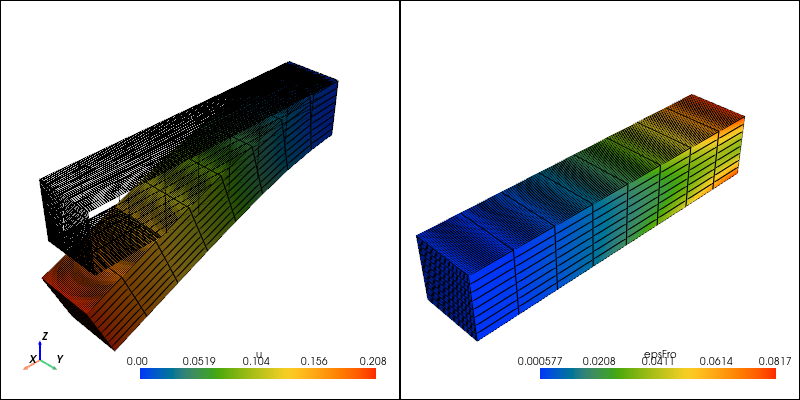

In [31]:
V_point = fem.functionspace(domain, ("Lagrange", 1))
eps_uh = e(uh)
sigma_uh = sigma(uh, lam, mu)

eps_fro = ufl_to_femFunction(ufl.sqrt(ufl.inner(eps_uh,eps_uh)), V_point)

subplotter = pv.Plotter(shape = (1,2), notebook = True, window_size=(800,400))
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pv.UnstructuredGrid(topology, cell_types, geometry)

subplotter.subplot(0,0)
# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
subplotter.add_mesh(grid, style="wireframe",
                    color="k")

warped = grid.warp_by_vector("u", factor=1.5)
subplotter.add_mesh(warped,
                    show_edges=True,
                    cmap = "rainbow",
                    scalar_bar_args={"title_font_size": 10, "label_font_size": 10})
subplotter.show_axes()

subplotter.subplot(0,1) # segundo subplot
grid["epsFro"] = eps_fro.x.array
subplotter.add_mesh(grid, cmap = "rainbow",
                    lighting = False,
                    scalars = "epsFro",
                    show_edges=True,
                    show_scalar_bar=True,
                    scalar_bar_args={"title_font_size": 10, "label_font_size": 10}) # mismo mallado

subplotter.show()

### **P4**
[1.5pts]

> **(a)** Fije ``lam=1`` y calcule el desplazamiento máximo $\max_\mathbf{x}||u_h||_2$, la deformación máxima $\max_\mathbf{x}||\mathbf{e}(u_h)||_\text{fro}$ y el estrés máximo $\max_\mathbf{x}||\mathbf{\sigma}(u_h)||_\text{fro}$ para ``mu=1,2,4,6,16,32``. Grafique sus resultados.

> **(b)** Fije ``lam=1`` y grafique el desplazamiento vertical $\mathbf{u}_h^z$, la magnitud de deformación $||\mathbf{e}(u_h)||_\text{fro}$ y la magnitud de estrés $||\mathbf{\sigma}(u_h)||_\text{fro}$ para ``mu=1,2,4,68,16,32`` a lo largo del eje central del modelo de barra elástica.

In [43]:
uh2 = solve_clamped(V, F, u_D, T, lam=1, mu=1)

norm_e_uh = ufl.inner(e(uh2),e(uh2))
norm_e_uh = ufl_to_femFunction(norm_e_uh,V_point)

np.sqrt(norm_e_eh.x.arraymax())

ValueError: Expecting a component matching the indices tuple.

In [47]:

u = solve_clamped(V, F, u_D, T, lam=1, mu=1)
u_arreglo = u.x.array
np.max(u_arreglo )

SyntaxError: positional argument follows keyword argument (<ipython-input-47-39bdab7fff60>, line 3)

In [42]:
# Con IA

lam = 1.0
mu_values = [1, 2, 4, 8, 16, 32]
results = []

for mu in mu_values:
    uh = solve_clamped(V, F, u_D, T, lam, mu)

    # Calcular deformación y tensión
    e = e(uh)
    s = sigma(uh, lam = 1, mu = 1)

    # Normas máximas
    max_displacement = np.max(np.linalg.norm(uh.x.array.reshape(-1,3), axis=1))
    max_strain = np.max(np.linalg.norm(e, ord='fro', axis=(0,1)))
    max_stress = np.max(np.linalg.norm(s, ord='fro', axis=(0,1)))

    results.append((mu, max_displacement, max_strain, max_stress))

# Graficar resultados
mu_vals = [r[0] for r in results]
disp = [r[1] for r in results]
strain = [r[2] for r in results]
stress = [r[3] for r in results]

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(mu_vals, disp, 'o-')
plt.xlabel('μ')
plt.ylabel('Max displacement')
plt.grid(True)

plt.subplot(132)
plt.plot(mu_vals, strain, 'o-')
plt.xlabel('μ')
plt.ylabel('Max strain (Frobenius norm)')
plt.grid(True)

plt.subplot(133)
plt.plot(mu_vals, stress, 'o-')
plt.xlabel('μ')
plt.ylabel('Max stress (Frobenius norm)')
plt.grid(True)
plt.show()

ValueError: Expecting a component matching the indices tuple.

### **P5**
[1.0pts]

> **(a)** Fije ``mu=1`` y calcule el desplazamiento máximo $\max_\mathbf{x}||u_h||_2$, la deformación máxima $\max_\mathbf{x}||\mathbf{e}(u_h)||_\text{fro}$ y el estrés máximo $\max_\mathbf{x}||\mathbf{\sigma}(u_h)||_\text{fro}$ para ``lam`` en una colección de valores en el rango $[-0.6,4.0]$ de su elección. Grafique sus resultados. **Indicación**: La colección de valores de ``lam`` que elija debe poseer al menos 5 elementos.

> **(b)** Fije ``mu=1`` y grafique el desplazamiento vertical $\mathbf{u}_h^z$, la magnitud de deformación $||\mathbf{e}(u_h)||_\text{fro}$ y la magnitud de estrés $||\mathbf{\sigma}(u_h)||_\text{fro}$ para ``lam`` en la colección de valores del índice anterior a lo largo del eje central del modelo de barra elástica.

